In [185]:
import csv
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import imutils
from imutils.contours import sort_contours
from imutils import build_montages

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
#matplotlib.use("Agg")

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [135]:
datafile = 'D:/Intelliza_Projects/TPL/OCR/meter_ocr/datasets/emnist_train1.csv'

In [157]:
def load_dataset(datasetPath):
    # initialize the list of data and labels
    data = []
    labels = []
    # loop over the rows of the A-Z handwritten digit dataset
    for row in open(datasetPath):
        # parse the label and image from the row
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and repshape them into a 28x28 matrix
        image = image.reshape((28, 28))
        image = np.flipud(image)
        image = np.rot90(image, 3)
        # update the list of data and labels
        data.append(image)
        labels.append(label)
    
    # convert the data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    # return a 2-tuple of the A-Z data and labels
    return (data, labels)

(data, labels) = load_dataset(datafile)

In [138]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

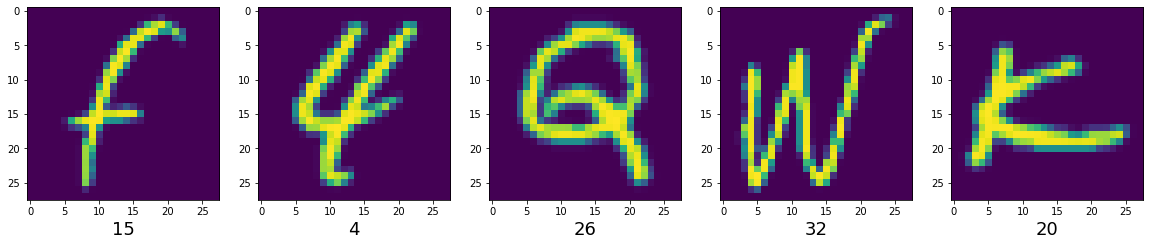

In [158]:
# verify the images have been loaded properly
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5/columns + 1, columns, i+1)
    plt.imshow(data[i])
    plt.xlabel(labels[i], fontsize=18)
   

In [159]:
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [171]:
# convert the labels from integers to vectors
train_labels = to_categorical(labels, dtype ="uint8")
    
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
X_train, X_test, y_train, y_test = train_test_split(data, train_labels, test_size=0.20, stratify=labels, random_state=42)

In [172]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

69120 17280
69120 17280


In [173]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

In [190]:
# create model

input_shape = (32, 32, 1)
img_width = 32
img_height = 32

EPOCHS = 50
INIT_LR = 1e-1
BS = 64

model = Sequential()

# 3 sets of CRP (Convolution, RELU, Pooling)
model.add(Conv2D(32, (3, 3), padding = "same", input_shape = input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding = "same", strides=(2, 2)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (5, 5), padding = "same", strides=(2, 2)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# Fully connected layers (w/ RELU)
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

# Fully connected layers (w/ RELU)
model.add(Dense(300))
model.add(Activation("relu"))

# Softmax (for classification)
model.add(Dense(36))
model.add(Activation("softmax"))
           
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
activation_59 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_60 (Activation)   (None, 8, 8, 64)        

In [193]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)                             
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)                            

In [194]:
print("[INFO] training network...")
H = model.fit(aug.flow(X_train, y_train, batch_size=BS), validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BS, epochs=EPOCHS, verbose=1, callbacks = [es, checkpoint])

[INFO] training network...
Epoch 1/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.4715 - acc: 0.8341
Epoch 00001: val_loss improved from inf to 0.29923, saving model to D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist.h5
1080/1080 [==============================] - 395s 365ms/step - loss: 0.4715 - acc: 0.8340 - val_loss: 0.2992 - val_acc: 0.8889
Epoch 2/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.4565 - acc: 0.8387
Epoch 00002: val_loss improved from 0.29923 to 0.28383, saving model to D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist.h5
1080/1080 [==============================] - 387s 358ms/step - loss: 0.4565 - acc: 0.8387 - val_loss: 0.2838 - val_acc: 0.8922
Epoch 3/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.4374 - acc: 0.8438
Epoch 00003: val_loss improved from 0.28383 to 0.27455, saving model to D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist.h5
1080/1080 [==============================]

Epoch 26/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.3565 - acc: 0.8706
Epoch 00026: val_loss improved from 0.24550 to 0.24412, saving model to D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist.h5
1080/1080 [==============================] - 504s 467ms/step - loss: 0.3564 - acc: 0.8707 - val_loss: 0.2441 - val_acc: 0.9091
Epoch 27/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.3588 - acc: 0.8704
Epoch 00027: val_loss improved from 0.24412 to 0.24321, saving model to D:/Intelliza_Projects/TPL/OCR/meter_ocr/stmeter_ocr_emnist.h5
1080/1080 [==============================] - 525s 486ms/step - loss: 0.3588 - acc: 0.8703 - val_loss: 0.2432 - val_acc: 0.9103
Epoch 28/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.3605 - acc: 0.8682
Epoch 00028: val_loss did not improve from 0.24321
1080/1080 [==============================] - 537s 497ms/step - loss: 0.3604 - acc: 0.8682 - val_loss: 0.2449 - val_acc: 0.9087
Epoch 29/50
1079/1

Text(0.5, 1.0, 'Accuracy Curves')

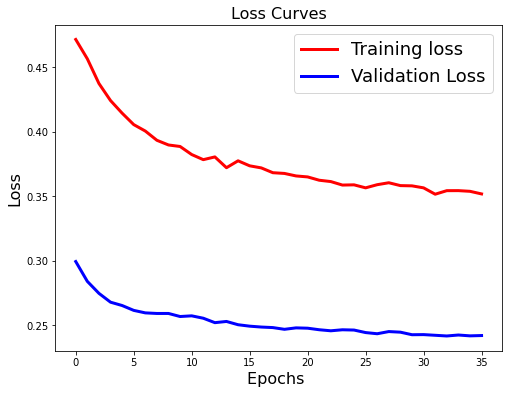

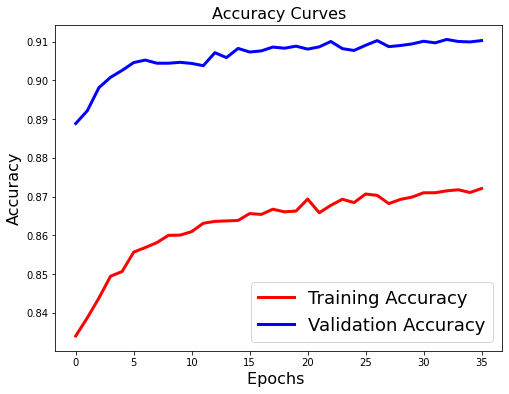

In [196]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(H.history['loss'],'r',linewidth=3.0)
plt.plot(H.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(H.history['acc'],'r',linewidth=3.0)
plt.plot(H.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

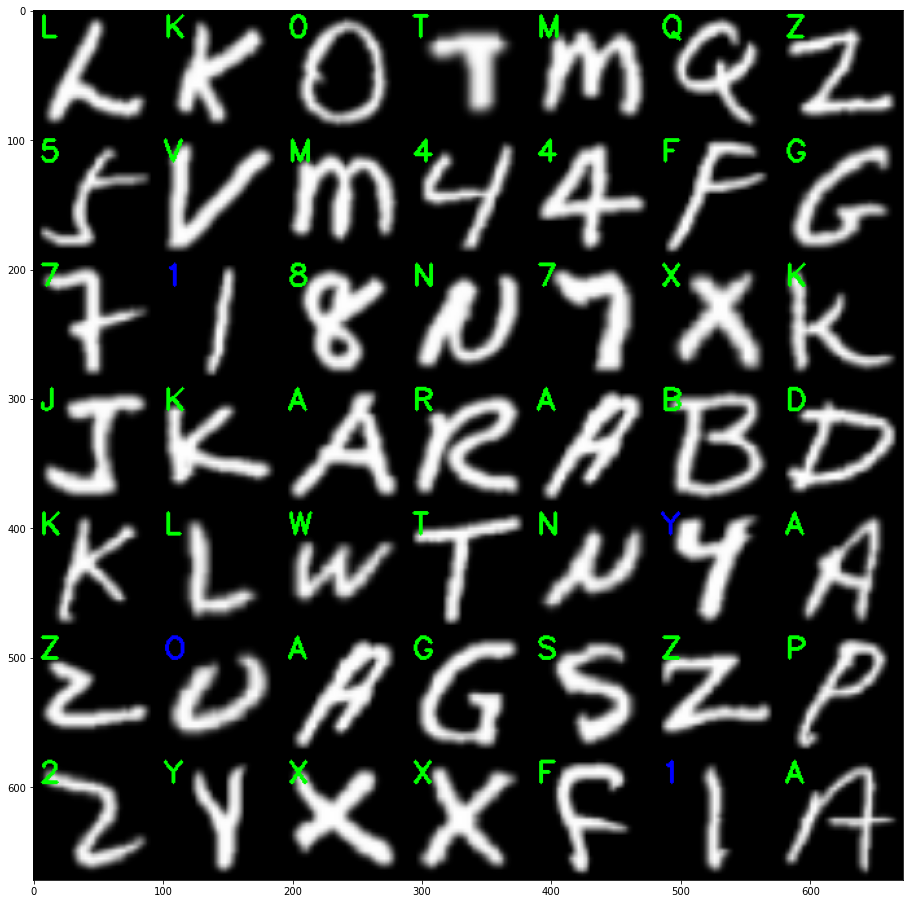

In [195]:
# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(y_test)), size=(49,)):
    # classify the character
    probs = model.predict(X_test[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]
    # extract the image from the test data and initialize the text
    # label color as green (correct)
    image = (np.squeeze(X_test[i]) * 255).astype("uint8")
    color = (0, 255, 0)
    # otherwise, the class label prediction is incorrect
    if prediction[0] != np.argmax(y_test[i]):
        color = (0, 0, 255)
    # merge the channels into one image, resize the image from 32x32
    # to 96x96 so we can better see it and then draw the predicted label on the image
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    # add the image to our list of output images
    images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

plt.figure(figsize=(16,16))
plt.imshow(montage)

In [265]:
def get_stmeter_no(imagepath):
    # Read the streetlight image
    image = cv2.imread(imagepath)
    
    # Convert the image to grayscale, and blur it to reduce noise
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Perform edge detection, find contours in the edge map, and sort the resulting contours from top-to-bottom
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="top-to-bottom")[0]
    
    # Initialize the list of contour bounding boxes and associated characters that we'll be OCR'ing
    chars = []

    # Loop over the contours
    for c in cnts:
        # Compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Filter out bounding boxes, ensuring they are neither too small nor too large
        #if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
        if cv2.contourArea(c) > 500:
        # extract the character and threshold it to make the character appear as *white* (foreground) on a *black* background, 
        # then grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] 
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=32)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=32)
            
            # re-grab the image dimensions (now that its been resized) and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 32 - tW) / 2.0)
            dY = int(max(0, 32 - tH) / 2.0)
        
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
            left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
        
            # prepare the padded image for classification via our handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
        
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))
            
    # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
    preds = model.predict(chars)
    
    for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]
        if prob * 100 > 50:        
            print(label)
            # draw the prediction on the image
            print("[INFO] {} - {:.2f}%".format(label, prob * 100))
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    return image

M
[INFO] M - 56.11%
B
[INFO] B - 63.41%
Z
[INFO] Z - 51.43%
G
[INFO] G - 70.07%
F
[INFO] F - 76.68%
9
[INFO] 9 - 72.07%
Z
[INFO] Z - 69.20%
8
[INFO] 8 - 64.28%


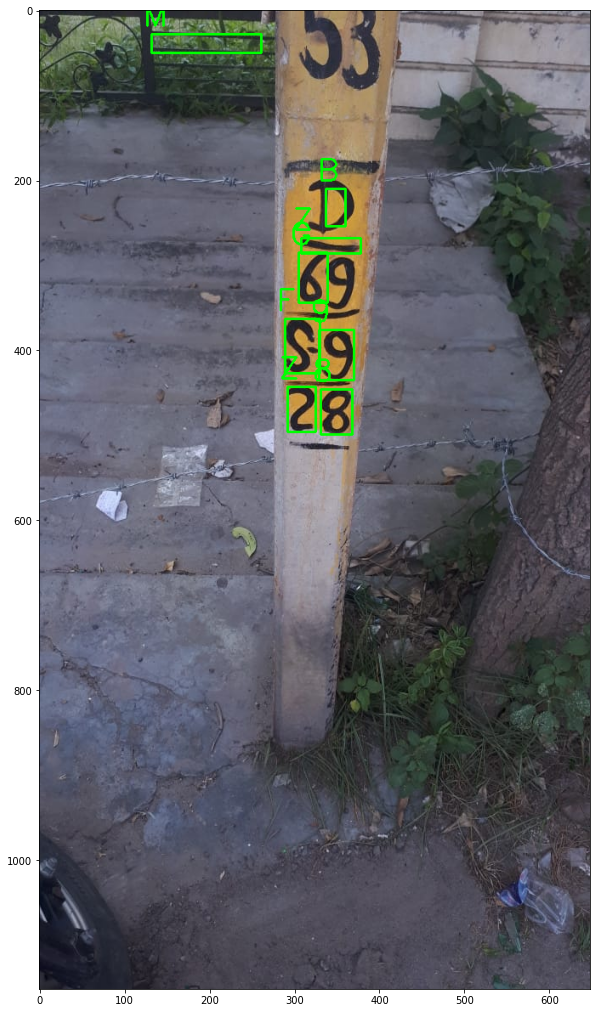

In [272]:
imagepath = 'D:\\Intelliza_Projects\\TPL\\OCR\\meter_ocr\\streetlight_images\\10.jpg'

meter_no = get_stmeter_no(imagepath)

plt.figure(figsize=(22,18))
img = cv2.cvtColor(meter_no, cv2.COLOR_BGR2RGB)
plt.imshow(img)